In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# conda install pytorch torchvision -c pytorch 
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut


In [76]:
# data/output_df의 파일들과 data/weather의 파일들을 읽어온다.
seoul_output_df = pd.read_csv('data/output_df/seoul_spring_df.csv')
seoul_spring_df = pd.read_csv('data/weather/seoul_spring.csv')

# 위에 파일들을 합친다.
seoul_df = pd.merge(seoul_output_df, seoul_spring_df, on='일시', how='left')

# 출력
seoul_df



,일시,일반봄배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,2000,72,3695,2660,6.3,18.9,-4.8,3.1,389.50
1,2000,72,3695,2660,11.9,23.5,1.8,30.7,440.90
2,2000,72,3695,2660,17.5,30.5,7.9,75.2,443.69
3,2001,8,4415,353,5.0,21.0,-6.1,18.1,396.53
4,2001,8,4415,353,13.6,28.2,2.1,12.3,492.04
...,...,...,...,...,...,...,...,...,...
61,2020,0,4661,1,11.1,23.8,1.9,16.9,637.52
62,2020,0,4661,1,18.0,30.0,9.2,112.4,564.83
63,2021,5,4663,228,9.0,22.9,-1.2,110.9,476.94
64,2021,5,4663,228,14.2,28.2,3.1,124.1,558.28


In [77]:
# 입력 데이터를 정규화한다. 일반봄배추:면적 (ha)	10a당 생산량 (kg)	생산량 (톤)	평균기온(°C)	최고기온(°C)	최저기온(°C)	월합강수량(00~24h만)(mm)	합계 일사량(MJ/m2)
scaler = MinMaxScaler()
seoul_df[['일반봄배추:면적 (ha)', '10a당 생산량 (kg)', '생산량 (톤)', '평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']] = scaler.fit_transform(seoul_df[['일반봄배추:면적 (ha)', '10a당 생산량 (kg)', '생산량 (톤)', '평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']])
seoul_df

,일시,일반봄배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,2000,0.818182,0.785502,1.000000,0.167702,0.244792,0.142857,0.000000,0.178047
1,2000,0.818182,0.785502,1.000000,0.515528,0.484375,0.479592,0.126085,0.313506
2,2000,0.818182,0.785502,1.000000,0.863354,0.848958,0.790816,0.329374,0.320859
3,2001,0.090909,0.938563,0.132707,0.086957,0.354167,0.076531,0.068524,0.196574
4,2001,0.090909,0.938563,0.132707,0.621118,0.729167,0.494898,0.042028,0.448280
...,...,...,...,...,...,...,...,...,...
61,2020,0.000000,0.990859,0.000376,0.465839,0.500000,0.484694,0.063042,0.831677
62,2020,0.000000,0.990859,0.000376,0.894410,0.822917,0.857143,0.499315,0.640111
63,2021,0.056818,0.991284,0.085714,0.335404,0.453125,0.326531,0.492462,0.408486
64,2021,0.056818,0.991284,0.085714,0.658385,0.729167,0.545918,0.552764,0.622849


In [78]:
# 데이터를 역순으로 정렬하여 전체 데이터를 80%는 학습용 데이터로, 20%는 테스트용 데이터로 나눈다.
seoul_df = seoul_df.sort_values(by='일시', ascending=False)
train = seoul_df[:int(len(seoul_df)*0.8)]
test = seoul_df[int(len(seoul_df)*0.8):]




In [79]:
train

,일시,일반봄배추:면적 (ha),10a당 생산량 (kg),생산량 (톤),평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
65,2021,0.056818,0.991284,0.085714,0.838509,0.864583,0.760204,0.822293,0.655053
64,2021,0.056818,0.991284,0.085714,0.658385,0.729167,0.545918,0.552764,0.622849
63,2021,0.056818,0.991284,0.085714,0.335404,0.453125,0.326531,0.492462,0.408486
62,2020,0.000000,0.990859,0.000376,0.894410,0.822917,0.857143,0.499315,0.640111
61,2020,0.000000,0.990859,0.000376,0.465839,0.500000,0.484694,0.063042,0.831677
60,2020,0.000000,0.990859,0.000376,0.254658,0.333333,0.244898,0.060302,0.509263
57,2019,0.000000,1.000000,0.000376,0.217391,0.177083,0.301020,0.108269,0.252418
58,2019,0.000000,1.000000,0.000376,0.527950,0.729167,0.403061,0.201919,0.474845
59,2019,0.000000,1.000000,0.000376,0.981366,1.000000,0.816327,0.158520,1.000000
56,2018,0.000000,0.974490,0.000376,0.906832,0.802083,0.739796,1.000000,0.630650


Epoch 1/100


2022-12-16 15:55:35.379517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 1s 11ms/step - loss: 0.0788
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0647
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0607
Epoch 4/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0574
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0542
Epoch 6/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0512
Epoch 7/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0472
Epoch 8/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0450
Epoch 9/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0413
Epoch 10/100
51/51 [==============================] - 1s 12ms/step - loss: 0.0386
Epoch 11/100
51/51 [==============================] - 1s 11ms/step - loss: 0.0370
Epoch 12/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0345
Epoch 13/100
51/51 [=================

2022-12-16 15:56:36.397961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


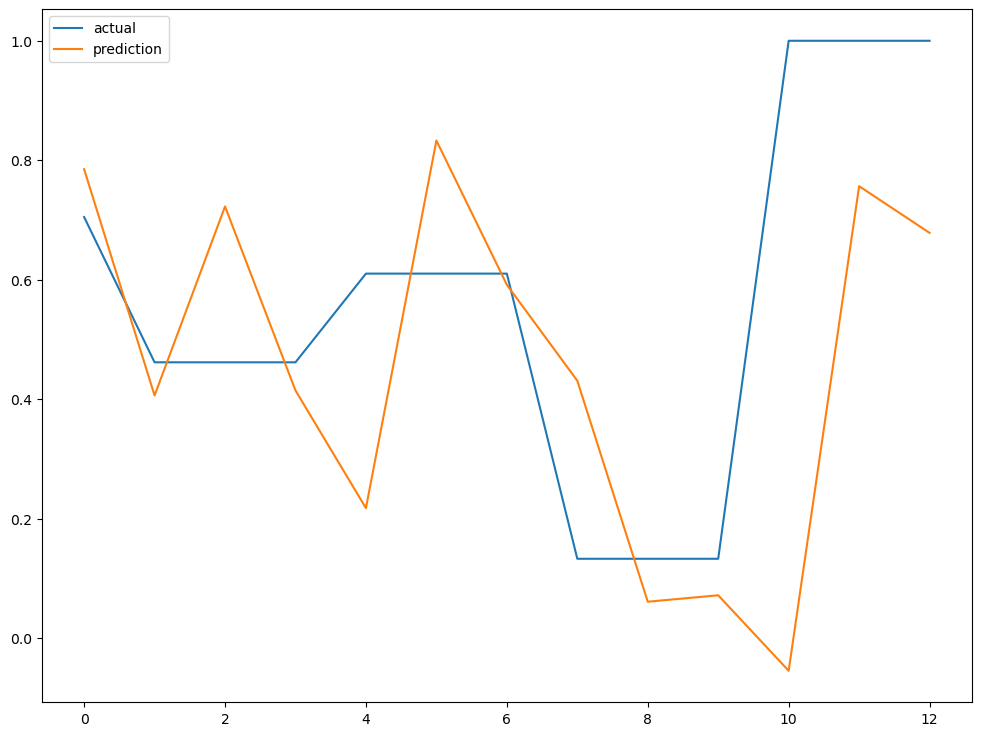

,actual,prediction
0,0.704887,0.784960
1,0.461654,0.406120
2,0.461654,0.722593
3,0.461654,0.414484
4,0.610150,0.217513
5,0.610150,0.832960
6,0.610150,0.591454
7,0.132707,0.430818
8,0.132707,0.060776
9,0.132707,0.071583


In [80]:
# 데이터셋 생성 함수
def make_dataset(data, label, window_size=1):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

# 학습용 데이터셋 생성
feature_cols = ['일반봄배추:면적 (ha)', '10a당 생산량 (kg)', '평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']
label_cols = ['생산량 (톤)']
train_feature = train[feature_cols]
train_label = train[label_cols]
train_feature, train_label = make_dataset(train_feature, train_label, 1)

# 테스트용 데이터셋 생성
test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, 1)

# 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(train_feature, train_label, epochs=100, batch_size=1, verbose=1)

# 모델 예측
pred = model.predict(test_feature)

# # 예측 결과를 원래 스케일로 되돌린다. 오류 발생
# pred = scaler.inverse_transform(pred.reshape(-1, 1))
# test_label = scaler.inverse_transform(test_label.reshape(-1, 1))

# 예측 결과를 그래프로 출력한다.
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 예측 결과를 데이터프레임으로 만든다.
result = pd.DataFrame(test_label, columns=['actual'])
result['prediction'] = pred
result

# 예측 결과를 엑셀 파일로 저장한다.
result.to_excel('result.xlsx', index=False)

# 모델 저장
model.save('model.h5')

